# scRNA - Example Application
-----------

This notebook showcases the various features of this package in a simple and
accessible example. I.e. we discuss the main parts of the transfer learning
and data simulation pipeline.

The main features of the scRNA package are: 
* simulation of scRNA read-count data according to a user-defined cell hierarchy 
* data splittings under various scenarios: random, stratified, overlapping, etc.
* setting up a data pre-processing pipeline, i.e. cell- and gene-filters, data transformations  
* source data clustering using non-negative matrix factorization with and without accompanying labels
* augmented clustering of the target data with user defined mix-in of the source data influence.

Throughout this notebook, we will employ supervised adjusted Rand score for
empirical evaluation. This is a supervised score which assumes access to 
ground truth labels which is, of course, implausible under practical considerations.

For discussions on unsupervised evaluations, we refer to our paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from functools import partial
from sklearn.manifold import TSNE
import sklearn.metrics as metrics

from scRNA.simulation import generate_toy_data, split_source_target
from scRNA.nmf_clustering import NmfClustering_initW, NmfClustering, DaNmfClustering
from scRNA.sc3_clustering_impl import data_transformation_log2, cell_filter, gene_filter

 
## 1. Simulating scRNA read count data
 
We will simulate 2000 cells with 1000 genes each whereas the cells exhibit
some hierarchical relation according to a user-defined, string-encoded tree structure.

- top:   1    2    3    *    *
- 1st:                4 5   6 *
- 2nd:                       7 8

In [2]:
n_genes = 1000
n_cells = 2000
cluster_spec = [1, 2, 3, [4, 5], [6, [7, 8]]]

In [103]:
np.random.seed(42)
data, labels = generate_toy_data(num_genes=n_genes, 
                                 num_cells=n_cells,
                                 cluster_spec=cluster_spec)
print(data.shape)

(1000, 2000)


Let's have a tSNE plot on the simulated data. We se that cluster are nicely 
distributed and easily recognizable.
To tweak the data, 'generate_toy_data' accepts a number of additional 
arguments, e.g. for inserting more noise.

([], <a list of 0 Text yticklabel objects>)

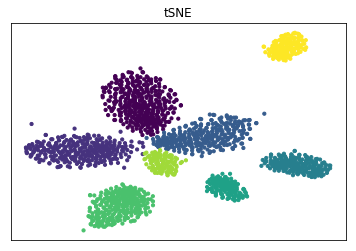

In [4]:
model = TSNE(n_components=2, random_state=0, init='pca', method='exact', metric='euclidean', perplexity=30)
ret = model.fit_transform(data.T)
plt.title('tSNE'.format())
plt.scatter(ret[:, 0], ret[:, 1], 10, labels)
plt.xticks([])
plt.yticks([])

Plotting the read counts as matrix reveals that many entries are zero, or 
close to zero. Cluster specific structures are partly visible from the raw data.

Text(0,0.5,'Genes')

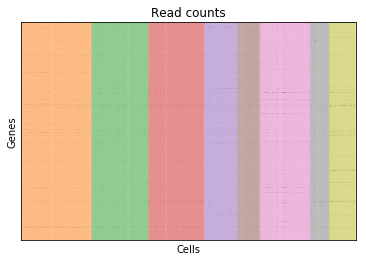

In [5]:
plt.figure(0)
inds = np.argsort(labels)
plt.pcolor(data[:, inds] / np.max(data), cmap='Greys')
plt.clim(0.,+1.)
plt.xticks([])
plt.yticks([])
for i in range(len(labels)):
    plt.vlines(i, 0, n_genes, colors='C{0}'.format(labels[inds[i]]), alpha=0.07)
plt.title('Read counts')
plt.xlabel('Cells')
plt.ylabel('Genes')

## 2. Splitting data into source and target 

Once the data is generated, the consecutive step is to sample the source and 
target data from the much larger corpus.
There are a number of ways to sample the data, e.g. by random, random but stratified,
exclusive clusters for source, overlapping clusters, etc.
The sampling method can be set by setting the corresponding 
'mode' argument in the 'split_source_target' function.

Splitting mode: 
- 1 = split randomly,
- 2 = split randomly, but stratified,
- 3 = split randomly, but anti-stratified (_not implemented_)
- 4 = Have some overlapping and some exclusive clusters,
- 5 = have only non-overlapping clusters
- 6 = Define source matrix clusters
- 7 = Define number of overlapping clusters

In this example, we will sample 100 target data and 400 source data using
mode 6 and sample from all clusters for our source dataset.

In [104]:
n_trg = 100
n_src = 400

In [105]:
np.random.seed(2)
data_source, data_target, true_labels_source, true_labels_target = \
    split_source_target(
        data,
        labels,
        target_ncells = n_trg,
        source_ncells = n_src,
        source_clusters = [1,2,3,4,5,6,7,8],
        mode = 6,
        common = 0,
        cluster_spec = cluster_spec
    )

trg_labels = np.unique(true_labels_target)
src_labels = np.unique(true_labels_source)
print('Source cluster: ', np.unique(true_labels_source))
print('Target cluster: ', np.unique(true_labels_target))

Source cluster:  [1 2 3 4 5 6 7 8]
Target cluster:  [1 2 3 4 5 6 7 8]


## 3. Clustering source data w/ and w/o labels 

Source data must be clustered with our non-negative matrix factorization
approach. If source data labels are provided, then decomposing matrices
are initialized accordingly, which (unsurprisingly) leads to higher 
in-sample accuracy scores than without. 

In [106]:
np.random.seed(1)
nmf = NmfClustering(data_source.copy(), np.arange(n_genes), labels=None, num_cluster=src_labels.size)
nmf.apply(alpha=1., l1=0.75, rel_err=1e-8)
score = metrics.adjusted_rand_score(true_labels_source, nmf.cluster_labels)
print('Adjusted Rand Score w/o labels: ', score)

Adjusted Rand Score w/o labels:  0.781977653697


In [107]:
np.random.seed(1)
nmf = NmfClustering_initW(data_source.copy(), np.arange(n_genes), labels=true_labels_source, num_cluster=src_labels.size)
nmf.apply(alpha=1., l1=0.75, rel_err=1e-8)
score = metrics.adjusted_rand_score(true_labels_source, nmf.cluster_labels)
print('Adjusted Rand Score w/ labels: ', score)

Adjusted Rand Score w/ labels:  0.903296534727


We can transform and filter any data using sc3 inspired methods: ie. 
log-transformations, gene-, and cell filters. 

Any scRNA clustering method inherits from the scRNA/AbstractClustering class
and is able to process data before 'apply'. You ony need to add corresponding
filters and transformations. Implementations for sc3-style filtering and 
transformations are stored in scRNA/sc3_clustering_impl.py. 

In [94]:
cell_filter_fun = partial(cell_filter, num_expr_genes=0, non_zero_threshold=-1)
gene_filter_fun = partial(gene_filter, perc_consensus_genes=1, non_zero_threshold=-1)
data_transf_fun = partial(data_transformation_log2)

np.random.seed(1)
nmf_transf = NmfClustering_initW(data_source.copy(), np.arange(n_genes), labels=true_labels_source, num_cluster=src_labels.size)

nmf_transf.add_cell_filter(cell_filter_fun)
nmf_transf.add_gene_filter(gene_filter_fun)
nmf_transf.set_data_transformation(data_transf_fun)

nmf_transf.apply(alpha=1., l1=0.75, rel_err=1e-8)
# nmf.print_reconstruction_error(data_source, nmf.dictionary, nmf.data_matrix)
score = metrics.adjusted_rand_score(true_labels_source, nmf_transf.cluster_labels)
print('Adjusted Rand Score: ', score)

Adjusted Rand Score:  1.0


## 4. Transfer learning: utilizing source data to help clustering target data 


In [108]:
print('(Iteration) adjusted Rand score:')
da_nmf_target = DaNmfClustering(nmf, data_target.copy(), np.arange(n_genes), num_cluster=trg_labels.size)
thetas = np.linspace(0, 1, 20)
res = np.zeros(thetas.size)
for i in range(thetas.size):
    da_nmf_target.apply(mix=thetas[i], alpha=1., l1=0.75, rel_err=1e-8, calc_transferability=False)
    # print(da_nmf_target.cluster_labels)
    res[i] = metrics.adjusted_rand_score(true_labels_target, da_nmf_target.cluster_labels)
    print('(', i,')', res[i])

(Iteration) adjusted Rand score:
( 0 ) 0.720700043035
( 1 ) 0.7627621199
( 2 ) 0.739380710124
( 3 ) 0.808251172244
( 4 ) 0.781062548023
( 5 ) 0.82497266221
( 6 ) 0.848211577268
( 7 ) 0.828625974334
( 8 ) 0.906004654021
( 9 ) 0.906004654021
( 10 ) 0.906004654021
( 11 ) 0.906004654021
( 12 ) 0.906004654021
( 13 ) 0.906004654021
( 14 ) 0.906004654021
( 15 ) 0.906004654021
( 16 ) 0.906004654021
( 17 ) 0.906004654021
( 18 ) 0.906004654021
( 19 ) 0.906004654021


Text(0,0.5,'adjusted Rand score')

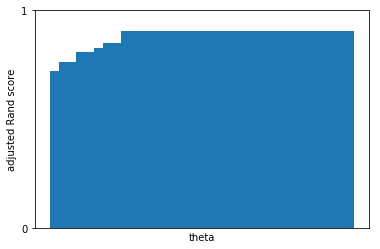

In [109]:
plt.figure(0)
plt.bar(thetas, res)
plt.xticks([])
plt.yticks([0., 1.])
plt.xlabel('theta')
plt.ylabel('adjusted Rand score')


## Summary

Transfer learning can improve clustering accuracy, if there is enough information 
overlap and the target data is insufficiently sampled (some cluster are underrepresented).

Transfer learning can also be used to induce properties of the source data into
the target data if the signal is too weak to be picked up by a clustering methods 
(interfered by a stronger signal).
